# PyTorch Autograd Intro
## Autograd is PyTorch module that computes gradients (derivatives) automatically
### Autograd constructs DAG (Directed Acyclic Graph) to record operations on tensors, then applied backpropagation to calculate partial derivates
* A GENTLE INTRODUCTION TO TORCH.AUTOGRAD: https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html?highlight=autograd
* AUTOMATIC DIFFERENTIATION WITH TORCH.AUTOGRAD: https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html?highlight=autograd
* THE FUNDAMENTALS OF AUTOGRAD: https://pytorch.org/tutorials/beginner/introyt/autogradyt_tutorial.html?highlight=autograd
* AUTOGRAD MECHANICS https://pytorch.org/docs/stable/notes/autograd.html

In [1]:
# !pip install torchviz
# !sudo apt install graphviz

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchviz import make_dot, make_dot_from_trace

import matplotlib.pyplot as plt

## Initialize Tensors with Gradient Calculation

In [3]:
x = torch.tensor(3.0, requires_grad=True)
x

tensor(3., requires_grad=True)

In [4]:
y = 3 * (x**2) + 15
y

tensor(42., grad_fn=<AddBackward0>)

# Compute gradients with backpropagation

In [5]:
y.backward()

### Derivative of the equation at \( x = 3 \)

The function was:

\[
$y = 3x^2 + 15$
\]

#### For finding the derivative with respect to \( x \);

\[
$\frac{\partial y}{\partial x} = 3 \cdot 2 \cdot x = 6x$
\]

#### The evaluation of the derivative where \( x = 3 \) is:

\[
$\frac{\partial y}{\partial x} \bigg|_{x=3} = 6 \cdot 3 = 18$
\]

#### We can access computed gradients in `.grad` attribute

In [6]:
x.grad

tensor(18.)

## Original data in tensor

In [7]:
x.data

tensor(3.)

## Is tensor a leaf in DAG Tree
* Remember autograd computes derivates in a backpropagation graph

In [8]:
x.is_leaf

True

## Grad function is used for computing the gradients 
### Since x is leaf, there no grad function
* Each mathematical operation have a unique function ex: *AddBackward0*, *SumBackward0*, *MulBackward0* etc.

In [9]:
x.grad_fn

# What about y?
### y is an intermediate step to calculate gradients of x, *y doen't have any gradients but has a gradient funciton*
#### See **chain rule**

In [10]:
print(f'data: {y.data}')
print(f'grad: {y.grad}')
print(f'grad function: {y.grad_fn}')
print(f'is_leaf?: {y.is_leaf}')
print(f'requires_grad? {y.requires_grad}')

data: 42.0
grad: None
grad function: <AddBackward0 object at 0x000001B130683400>
is_leaf?: False
requires_grad? True


C:\Users\batuy\AppData\Local\Temp\ipykernel_13696\1784889899.py:2: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen/core/TensorBody.h:494.)
  print(f'grad: {y.grad}')


# Another Example
Let the function be:
\[
    $y= 6x^2 + 2x + 4$
\] 

The derivative of the function will be:
${\frac{\partial y}{\partial x}} = 12x + 2$

When `x = 2`:
${\frac{\partial y}{\partial x}}\bigg|_{x=2} = 12 \cdot 2 + 2 = 26$

In [11]:
x = torch.tensor(2.0, requires_grad=True)
y = 6*(x**2) + 2*x + 4

print(f'Result y: {y}')

y.backward()
print(f'Derivative of the equation at x=2 is: {x.grad}')

Result y: 32.0
Derivative of the equation at x=2 is: 26.0


# Partial Derivative Example
### $y= x_1^3 + x_2^2 + 4x_1x_2 + 5$ 
#### ${\frac{\partial y}{\partial x_1}} = 3x_1^2 + 4x_2$
#### ${\frac{\partial y}{\partial x_2}} = 2x_2 + 4x_1$

#### ${\frac{\partial y}{\partial x_1}}\bigg|_{x_1=3, x_2=4} = 3 \cdot 3^2 + 4 \cdot 4 = 43$
#### ${\frac{\partial y}{\partial x_2}}\bigg|_{x_1=3, x_2=4} = 2 \cdot 4 + 4 \cdot 3 = 20$

In [12]:
x1 = torch.tensor(3., requires_grad=True)
x2 = torch.tensor(4., requires_grad=True)
 
y = x1**3 + x2**2 + 4*x1*x2 + 5
 
print(x1.data)
print(x2.data)
print(y.data)

tensor(3.)
tensor(4.)
tensor(96.)


In [13]:
y.backward()
print(f'Partial derivative with respect to x1: {x1.grad}')
print(f'Partial derivative with respect to x2: {x2.grad}')

Partial derivative with respect to x1: 43.0
Partial derivative with respect to x2: 20.0


# IMPORTANT: By default, PyTorch accumulates (sums) gradients
### Multiple calls to backward()

In [14]:
x = torch.tensor(3.0, requires_grad=True)
y = 3 * (x**2) + 15
y.backward()
x.grad

tensor(18.)

In [15]:
y = 3 * (x**2) + 15
y.backward()
x.grad

tensor(36.)

### Zero gradients before next backward() call

With `zero_()` we can reset the gradient.

In [16]:
x.grad.zero_() 
y = 3 * (x**2) + 15
y.backward()
x.grad

tensor(18.)

Because we reset the gradient, the result will be 18 again: $0+18 = 18$

In [17]:
x.grad.zero_() # 
y = 3 * (x**2) + 15
y.backward()
x.grad

tensor(18.)

# Automatic Inclusion/Exclusion from the DAG

In [18]:
x = torch.rand(5, 5)
y = torch.rand(5, 5)
z = torch.rand((5, 5), requires_grad=True)

a = x + y
print(f"Does 'a' require gradients?: {a.requires_grad}")
b = x + z
print(f"Does 'b' require gradients?: {b.requires_grad}")

Does 'a' require gradients?: False
Does 'b' require gradients?: True


# Remove a tensor from the backpropagation graph
## Detaching a tensor

In [19]:
tensor_with_grad = torch.rand((2, 2), requires_grad=True)
tensor_with_grad

tensor([[0.0323, 0.4457],
        [0.1996, 0.7184]], requires_grad=True)

In [20]:
tensor_with_grad.detach()

tensor([[0.0323, 0.4457],
        [0.1996, 0.7184]])

### Note that this is a non-destructive operation

In [21]:
tensor_with_grad.requires_grad

True

# Common use: detach and clone a tensor

In [22]:
tensor_clone = tensor_with_grad.detach().clone()
tensor_clone

tensor([[0.0323, 0.4457],
        [0.1996, 0.7184]])

# Autograd Profiling

In [23]:
x = torch.randn((1, 1), requires_grad=True)

with torch.autograd.profiler.profile() as prof:
    for _ in range(100):
        y = x ** 2 + x
        y.backward()

In [24]:
print(prof.key_averages().table(sort_by='self_cpu_time_total'))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                              aten::pow        22.61%       2.934ms        27.14%       3.521ms      17.607us           200  
                                              aten::mul        12.83%       1.664ms        24.47%       3.175ms      15.877us           200  
                                              aten::add         9.24%       1.198ms         9.24%       1.198ms       5.991us           200  
                                           PowBackward0         7.19%     933.100us        43.65%       5.664ms      56.642us           100  
      

# Backpropagation Visulizations
### NOTE: You need to install graphviz to your computer!

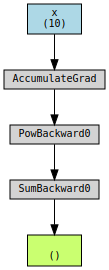

In [25]:
x = torch.ones(10, requires_grad=True)

y = (x**2).sum()

make_dot(y, params={'x':x}, show_attrs=False, show_saved=False)
#make_dot(r, params={'x':x}, show_attrs=False, show_saved=False).render('backprop_graph', format='png')

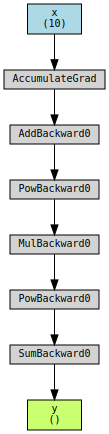

In [26]:
x = torch.ones(10, requires_grad=True)

y = x + 10
z = y ** 2
z = z * 10
y = (z**2).sum()

# Make a render of graph
make_dot(y, params={'x':x}, show_attrs=False, show_saved=False).render('backprop_graph', format='png')
# Plot graph
make_dot(y, params={'x':x, 'y':y}, show_attrs=False, show_saved=False)